In [55]:
import sqlite3
import os
import pandas as pd
import numpy as np
import re
from pathlib import Path

from google.protobuf.json_format import MessageToDict
from google.protobuf.descriptor import FieldDescriptor as FD
from events.gen import messages_pb2, asd_events_pb2
from utils.build_raw_inputs import find_sim_db, find_scenarios

ROOT = Path("/store/kruu/eye_tracking/training_data")
SAVE = Path("/store/kruu/eye_tracking/asd")

In [3]:
df_asd = pd.read_parquet("/store/regd/asd.parquet")
df_asd.head(5)

,epoch_ms,event_name,data,participant,scenario
index,,,,,
0,1758697868960,mouse_position,"{'x': 2539, 'y': 1788}",001,1
1,1758697869010,mouse_position,"{'x': 2139, 'y': 1519}",001,1
2,1758697869110,mouse_position,"{'x': 2045, 'y': 1320}",001,1
3,1758697869110,mouse_position,"{'x': 2041, 'y': 1287}",001,1
4,1758697869160,mouse_position,"{'x': 2041, 'y': 1100}",001,1


In [4]:
df_asd.groupby(["scenario"])["event_name"].value_counts()

scenario  event_name           
1         track_label_position     557468
          track_screen_position    467487
          mouse_position           389323
          distance_measurement      16833
          popup                      2201
          transfer                   1299
          clearance                   705
          sep_tool                    391
          route_interaction           370
          speed_vector                211
          keyboard_shortcut            64
2         track_label_position     654716
          track_screen_position    561987
          mouse_position           396321
          distance_measurement       9825
          popup                      2242
          transfer                   1571
          clearance                   864
          sep_tool                    507
          route_interaction           388
          speed_vector                155
          keyboard_shortcut            38
          track_mark                    2
3 

In [204]:
# mouse position
print(df_asd.query(f"event_name == 'mouse_position'").data.iloc[0], end="\n\n")

# Position on aircraft on the screen + labels
print(df_asd.query(f"event_name == 'track_label_position'").data.iloc[0])
print(df_asd.query(f"event_name == 'track_screen_position'").data.iloc[0], end="\n\n")

# Distance measurement tool. 
# WARNING: can have different information from one line to another (added / positionUpdated)
print(df_asd.query(f"event_name == 'distance_measurement'").data.iloc[0], end="\n\n")

# Popup window
print(df_asd.query(f"event_name == 'popup'").data.iloc[0], end="\n\n")

# Transfer (probably when tranfering the aircraft to the next airspace)
print(df_asd.query(f"event_name == 'transfer'").data.iloc[0], end="\n\n")

# Instruction given to aircraft
print(df_asd.query(f"event_name == 'clearance'").data.iloc[0], end="\n\n")

# Separation tool -> Open for 1 aircraft / connected between 2 aircraft / closed
print(df_asd.query(f"event_name == 'sep_tool'").data.iloc[1], end="\n\n")

# Route interaction (modification of waypoint of an aircraft route ?)
print(df_asd.query(f"event_name == 'route_interaction'").data.iloc[4], end="\n\n")

# Speed vector (different modes selected: OFF, ON, for one specific a/c...)
print(df_asd.query(f"event_name == 'speed_vector'").data.iloc[5], end="\n\n")

# Keyboard shortcut
print(df_asd.query(f"event_name == 'keyboard_shortcut'").data.iloc[2], end="\n\n")

# track mark (rare / ask for clarification)
print(df_asd.query(f"event_name == 'track_mark'").data.iloc[2], end="\n\n")

{'x': 2088, 'y': 971}

{'x': 1369, 'y': 1024, 'width': 141, 'height': 86, 'hovered': True, 'flightId': {'trackNumber': 11}}
{'x': -486, 'y': 1280, 'flightId': {'trackNumber': 23}}

{'added': {'first': {'flightId': {'trackNumber': 1}}, 'second': {'latLon': {'latDeg': 56.366797269015066, 'lonDeg': 13.204522552761844}}}}

{'name': 'CFLMenu', 'opened': True, 'flightId': {'trackNumber': 1}}

{'transferType': 'FORCE_ASSUME', 'flightId': {'trackNumber': 20}}

{'clearanceType': 'cleared-flight-level', 'clearance': '370', 'flightId': {'trackNumber': 1}}

{'connected': {'flightId1': {'trackNumber': 13}, 'flightId2': {'trackNumber': 21}}, 'type': 'A'}

{'flightId': {'uuid': '9ae3e4dc-5113-4eb6-a178-7fca730c87a9'}, 'actionType': 'DRAG_STARTED', 'value': '5624N01341E'}

{'visibility': {'visible': True, 'flightId': {'trackNumber': 17}}}

{'actionName': 'Extend Track Label'}

{'markType': 'FIRST_TYPE', 'markVariant': 'FIRST_VARIANT', 'markScope': 'User', 'markSet': True, 'flightId': {'trackNumber': 2

In [6]:
df_asd['epoch_ms'] = pd.to_numeric(df_asd['epoch_ms'])
df_asd = df_asd.sort_values('epoch_ms')

# Median inter-event interval per type
sampling = (
    df_asd.groupby(['participant', 'scenario', 'event_name'])['epoch_ms']
      .apply(lambda x: np.median(np.diff(np.sort(x))))
      .to_frame('median_dt_ms')
)
sampling

/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


median_dt_ms
participant scenario event_name                         
001         1        clearance                   78654.0
                     distance_measurement         3034.0
                     mouse_position                100.0
                     popup                        4243.0
                     sep_tool                     2725.0
...                                                  ...
023         3        popup                        2839.0
                     sep_tool                     2279.0
                     track_label_position            0.0
                     track_screen_position           0.0
                     transfer                    24314.5

[562 rows x 1 columns]

****
# Helper functions
****

In [ ]:
_CAMEL_RE = re.compile(r'(?<!^)(?=[A-Z])')

def _to_snake(s):
    # fast path for non-strings
    if not isinstance(s, str):
        return s
    # special known names
    specials = {
    "latDeg": "lat_deg",
    "lonDeg": "lon_deg",
    "trackNumber": "track_number",
    "flightId": "flight_id",
    "latLon": "lat_lon",
    "positionUpdated": "position_updated",
    "measurementId": "measurement_id",
    "transferType": "transfer_type", 
    "clearanceType": "clearance_type", 
    "flightId1": "flight_id1",
    "flightId2": "flight_id2",
    "modeUpdated": "mode_updated",
    "lengthSeconds":"length_seconds",
    "actionName": "action_name",
    "markType": "mark_type",
    "markVariant": "mark_variant",
    "markScope": "mark_scope",
    "markSet": "mark_set",
    "flightId": "flight_id",
    "trackNumber": "track_number",
}
    if s in specials:
        return specials[s]
    # generic camelCase/PascalCase -> snake_case
    return _CAMEL_RE.sub('_', s).lower()

def _normalize_keys(obj):
    """Recursively convert dict/list keys to snake_case."""
    if isinstance(obj, dict):
        out = {}
        for k, v in obj.items():
            out[_to_snake(k)] = _normalize_keys(v)
        return out
    if isinstance(obj, list):
        return [_normalize_keys(x) for x in obj]
    return obj

def _safe_get(d, k):
    return None if not isinstance(d, dict) else d.get(k)

In [56]:
def normalize_by_schema(df_event, event_name, schema):
    sub = df_event.loc[df_event["event_name"] == event_name].copy()
    if sub.empty:
        return sub[["epoch_ms", "participant", "scenario"]].assign(**{}), pd.DataFrame(columns=["index","issue"])

    # Preprocess to account for oneof change added | removed | position updated into a flat dict per row
    if "preprocess" in schema and callable(schema["preprocess"]):
        payload = schema["preprocess"](sub["data"])
        payload.index = sub.index
    else:
        payload = pd.json_normalize(sub["data"])
        payload.index = sub.index

    # Ensure required keys exist (create as NA if missing)
    for k in schema.get("columns_out", []):
        if k not in payload.columns:
            payload[k] = pd.NA

    # type coercions (nullable)
    for k in schema.get("numeric_int", set()):
        if k in payload.columns:
            payload[k] = pd.to_numeric(payload[k], errors="coerce").astype("Int32")
    for k in schema.get("numeric_float", set()):
        if k in payload.columns:
            payload[k] = pd.to_numeric(payload[k], errors="coerce").astype("Float64")
    for k in schema.get("boolean", set()):
        if k in payload.columns:
            payload[k] = payload[k].map(lambda v: None if pd.isna(v) else bool(v)).astype("boolean")

    # Build clean output with a prefix (optional)
    pref = schema.get("prefix", "")
    core = sub[["epoch_ms","participant","scenario"]].copy()
    for col in schema.get("columns_out", payload.columns.tolist()):
        if col in payload.columns:
            core[pref + col] = payload[col]
        else:
            core[pref + col] = pd.NA

    # Issues (basic: missing required)
    issues = []
    for k in schema.get("required", []):
        miss = core[pref + k].isna() if (pref + k) in core.columns else payload[k].isna()
        if miss.any():
            issues.append(pd.DataFrame({"index": core.index[miss], "issue": f"{event_name}:missing:{k}"}))
    issues = pd.concat(issues, ignore_index=True) if issues else pd.DataFrame(columns=["index","issue"])
    return core.reset_index(drop=True), issues

****
# Mouse positions
****

In [100]:
SCHEMA_MOUSE = {
    "prefix": "mouse_",
    "required": {"x", "y"},
    "numeric_int": {"x", "y"},
    "numeric_float": set(),
    "boolean": set(),
    "columns_out": ["x", "y"]              # we only want x,y emitted; epoch/ids come from the outer df
}

mouse_clean, mouse_issues = normalize_by_schema(df_asd, event_name="mouse_position", schema=SCHEMA_MOUSE)

In [107]:
print(mouse_clean.mouse_x.isnull().sum())
print(mouse_clean.mouse_y.isnull().sum())
print((mouse_clean.mouse_y.isnull() & mouse_clean.mouse_x.isnull()).sum())
print((mouse_clean.mouse_y.isnull() | mouse_clean.mouse_x.isnull()).sum())

116
12
0
128


In [111]:
print(mouse_clean.mouse_x.max())
print(mouse_clean.mouse_x.min())
print(mouse_clean.mouse_y.max())
print(mouse_clean.mouse_y.min())

3839
1
2132
-27


<Axes: >

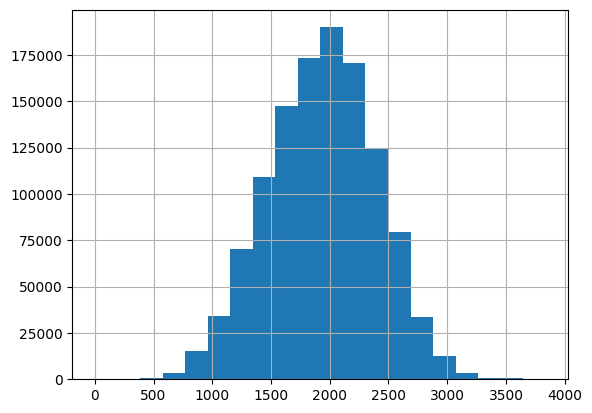

In [115]:
mouse_clean.mouse_x.hist(bins = 20)

Comments:
- Obviously wrong pixel assignement in the mouse positions -> out of the screen
- Are they even pixels ?
- Might what to have a closer look at the screen frame and the similarities with gaze values. However, it's not really a big deal if it's not pixels as they will be normalized, but still interesting to look at.
- Cross check with other fields x/y values
- NB: 4k = 3480 x 2160

****
# A/C + labels positions
****

In [ ]:
# Don't exactly have the same number of messages for screen and label (more labels than screens)
# Some participant/scenarios are missing
df_asd.query("event_name in ['track_label_position', 'track_screen_position']").groupby(["participant", "scenario", "event_name"]).size().unstack(fill_value=0)


event_name            track_label_position  track_screen_position
participant scenario                                             
001         1                        27458                  24285
            2                        34723                  31201
            3                        30866                  27468
002         1                        30640                  27594
            2                        28578                  25175
            3                        27022                  23904
003         1                        26415                  21831
            2                        34207                  29234
            3                        30055                  25059
004         1                        24687                  20903
            2                        25061                  21793
005         1                        26956                  22068
            2                        31376                  26199
            3                        27899                  23385
006         1                        27787                  23629
            2                        30744                  25352
            3                        33818                  27896
007         1                        25981                  20955
            2                        22725                  19059
            3                        36331                  31235
008         1                        32797                  28461
            2                        36633                  32429
            3                        30733                  26816
009         1                        25978                  22166
            3                        32885                  28806
010         1                        28163                  23619
            2                        33869                  29850
            3                        29625                  25371
011         1                        32578                  26216
            2                        44626                  37715
            3                        36739                  29640
013         1                         8518                   7129
            2                        33153                  29565
            3                        29675                  26425
014         1                        30277                  25264
            2                        31257                  26217
            3                        28599                  23633
015         1                        31122                  26467
            2                        47467                  42118
            3                        37416                  31992
016         1                        31305                  24946
            2                        44161                  37086
            3                        41086                  34976
017         1                        28005                  23262
            2                        30041                  24401
            3                        31901                  27364
018         1                        28600                  23046
            2                        34369                  28681
            3                        30270                  24443
019         1                        29938                  24786
            2                        40816                  35637
            3                        40426                  35002
020         1                        28801                  24490
            2                        33149                  28107
            3                        33860                  28970
023         1                        31462                  26370
            2                        37761                  32168
            3                        37008                  31516

In [9]:
# on_pip == True -> track label is currently displayed in an auxiliary "picture-in-piture" window. 

SCHEMA_LABEL = {
    "required": {"track_number", "x", "y", "width", "height", "visible", "hovered", "selected", "on_pip", "flight_id"},
    "numeric_int": {"track_number", "x", "y", "width", "height"},
    "boolean": {"visible", "hovered", "selected", "on_pip"},
    "nested": {"flight_id"},
    "prefix": "label_",
}

SCHEMA_SCREEN = {
    "required": {"track_number", "x", "y", "visible", "flight_id"},
    "numeric_int": {"track_number", "x", "y"},
    "boolean": {"visible"},
    "nested": {"flight_id"},
    "prefix": "screen_",
}

clean_screen, issues_screen = normalize_by_schema(df_asd, "track_screen_position", SCHEMA_SCREEN)
clean_label,  issues_label  = normalize_by_schema(df_asd, "track_label_position",  SCHEMA_LABEL)

# Long-format unified table with consistent core columns: x,y,track_number,visible and flight fields
screen_long = clean_screen.rename(columns={
    "screen_x":"x", "screen_y":"y",
    "screen_visible":"visible",
}).assign(event_name="track_screen_position")

label_long = clean_label.rename(columns={
    "label_x":"x", "label_y":"y",
    "label_visible":"visible",
}).assign(event_name="track_label_position")

positions_long = pd.concat([screen_long, label_long], ignore_index=True, sort=False)

# Combine issues
issues = pd.concat([issues_screen, issues_label], ignore_index=True)

In [23]:
positions_long

,epoch_ms,participant,scenario,x,y,screen_flightId.trackNumber,visible,screen_track_number,screen_flight_id,event_name,label_width,label_height,label_hovered,label_flightId.trackNumber,label_onPip,label_selected,label_flight_id,label_on_pip,label_track_number
0,1722754209666,006,1,-486,1280,23.0,<NA>,<NA>,NaN,track_screen_position,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
1,1722754209675,006,1,612,1915,4.0,True,<NA>,NaN,track_screen_position,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
2,1722754209687,006,1,715,2547,11.0,<NA>,<NA>,NaN,track_screen_position,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
3,1722754209695,006,1,901,2375,10.0,<NA>,<NA>,NaN,track_screen_position,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
4,1722754209704,006,1,1102,1839,16.0,True,<NA>,NaN,track_screen_position,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401768,1758897800244,003,2,3629,214,NaN,True,<NA>,NaN,track_label_position,85,52,<NA>,647.0,NaN,<NA>,NaN,<NA>,<NA>
3401769,1758897800244,003,2,1703,1645,NaN,True,<NA>,NaN,track_label_position,85,52,<NA>,649.0,NaN,<NA>,NaN,<NA>,<NA>
3401770,1758897800244,003,2,3176,2055,NaN,True,<NA>,NaN,track_label_position,85,52,<NA>,654.0,NaN,<NA>,NaN,<NA>,<NA>
3401771,1758897800244,003,2,1600,447,NaN,True,<NA>,NaN,track_label_position,101,86,<NA>,672.0,NaN,<NA>,NaN,<NA>,<NA>


In [122]:
print(positions_long.x.isna().sum())
print(positions_long.y.isna().sum())

92
18701


In [96]:
positions_long.label_width.max()

np.int32(440)

Comments. We can add:
- the position of the track_screen_position to correlate it with the gaze and mouse
- an inidcator stating if the gaze is looking at the label using label width and height
- label_hovered (for the mouse) (Nan = False)
- label_onPip (within the zoomed window) (Nan = False)
- label_selected (Nan = False) 
- Visible give an indicator if the flight (screen) is visible on the screen
- (optional: flight_id to identify the flight associated with the task)

WARNING:
- Not the same number of x and y values
- Way out of the screen resolution (x_max = 5417 , y_max = 4598)


****
# Distance Measurement
****

In [ ]:
# --------- utilities ---------

def _flatten_mp(prefix, mp, *, log_conflicts=False):
    """MeasurementPoint -> flat dict under <prefix>_* with backfill from flight_id.track_number."""
    out = {}
    if not isinstance(mp, dict):
        return out

    fi = _safe_get(mp, "flight_id") or {}

    # --- track_number with backfill from nested flight_id.track_number ---
    tn_top = _safe_get(mp, "track_number")
    tn_fi  = _safe_get(fi, "track_number")
    tn = tn_top if tn_top is not None else tn_fi
    out[f"{prefix}_track_number"] = tn

    if log_conflicts and (tn_top is not None and tn_fi is not None and tn_top != tn_fi):
        out[f"{prefix}_track_number_conflict"] = True  # boolean flag

    # --- kind + lat/lon or flight_id expansion ---
    if isinstance(_safe_get(mp, "lat_lon"), dict):
        out[f"{prefix}_kind"] = "lat_lon"
        out[f"{prefix}_lat_deg"] = _safe_get(mp["lat_lon"], "lat_deg")
        out[f"{prefix}_lon_deg"] = _safe_get(mp["lat_lon"], "lon_deg")
    elif isinstance(fi, dict) and len(fi):
        out[f"{prefix}_kind"] = "flight_id"
        for k, v in fi.items():
            out[f"{prefix}_flight_{k}"] = v
    else:
        out[f"{prefix}_kind"] = "unknown"

    return out

def preprocess_distance_measurement(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)  # <<< normalize once, deeply
        row = {}
        if not isinstance(d, dict):
            rows.append(row); continue

        if isinstance(_safe_get(d, "added"), dict):
            a = d["added"]
            row["change"] = "added"
            row["measurement_id"] = _safe_get(a, "measurement_id")
            row.update(_flatten_mp("first",  _safe_get(a, "first")))
            row.update(_flatten_mp("second", _safe_get(a, "second")))

        elif isinstance(_safe_get(d, "position_updated"), dict):
            u = d["position_updated"]
            row["change"] = "position_updated"
            row["measurement_id"] = _safe_get(u, "measurement_id")
            s = _safe_get(u, "start") or {}
            e = _safe_get(u, "end") or {}
            row["start_x"] = _safe_get(s, "x"); row["start_y"] = _safe_get(s, "y")
            row["end_x"]   = _safe_get(e, "x"); row["end_y"]   = _safe_get(e, "y")

        elif isinstance(_safe_get(d, "removed"), dict):
            r = d["removed"]
            row["change"] = "removed"
            row["measurement_id"] = _safe_get(r, "measurement_id")  # may be None

        rows.append(row)
    return pd.DataFrame(rows)

In [131]:
SCHEMA_DISTANCE = {
    "preprocess": preprocess_distance_measurement,
    "columns_out": [
        "change","measurement_id",
        "first_track_number","first_kind","first_lat_deg","first_lon_deg",
        "second_track_number","second_kind","second_lat_deg","second_lon_deg",
        "start_x","start_y","end_x","end_y",
    ],
    "numeric_int": {"measurement_id","first_track_number","second_track_number","start_x","start_y","end_x","end_y"},
    "numeric_float": {"first_lat_deg","first_lon_deg","second_lat_deg","second_lon_deg"},
    "boolean": set(),
}

In [132]:
dm_clean, dm_issues = normalize_by_schema(df_asd, "distance_measurement", SCHEMA_DISTANCE)

In [133]:
dm_clean

,epoch_ms,participant,scenario,change,measurement_id,first_track_number,first_kind,first_lat_deg,first_lon_deg,second_track_number,second_kind,second_lat_deg,second_lon_deg,start_x,start_y,end_x,end_y
0,1722754261991,006,1,added,<NA>,1,flight_id,<NA>,<NA>,<NA>,lat_lon,56.366797,13.204523,<NA>,<NA>,<NA>,<NA>
1,1722754262088,006,1,position_updated,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,1509,821,1793,1291
2,1722754262839,006,1,position_updated,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,1511,825,1793,1291
3,1722754264869,006,1,removed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1722754328819,006,1,added,<NA>,3,flight_id,<NA>,<NA>,<NA>,lat_lon,56.377219,13.623955,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41004,1758897525623,003,2,position_updated,1,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,1833,1154,1766,1296
41005,1758897528771,003,2,position_updated,1,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,1830,1158,1766,1296
41006,1758897533779,003,2,position_updated,1,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,1828,1161,1766,1296
41007,1758897534985,003,2,position_updated,1,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,1826,1165,1766,1296


In [134]:
dm_clean.groupby(["participant", "scenario"])["change"].size().unstack(fill_value=0)

scenario,1,2,3
participant,,,
001,264,122,147
002,25,92,0
003,1265,250,859
004,4,0,0
005,151,83,105
006,1852,301,589
007,70,107,204
008,1391,283,357
009,696,0,386


In [91]:
dm_clean.query("change == 'removed'")

,epoch_ms,participant,scenario,change,measurement_id,first_track_number,first_kind,first_lat_deg,first_lon_deg,second_track_number,second_kind,second_lat_deg,second_lon_deg,start_x,start_y,end_x,end_y
3,1722754264869,006,1,removed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
11,1722754340150,006,1,removed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
12,1722754340150,006,1,removed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
26,1722754447851,006,1,removed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
29,1722754477823,006,1,removed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40984,1758897047857,003,2,removed,1,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
40987,1758897116456,003,2,removed,1,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
40992,1758897242961,003,2,removed,1,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
40998,1758897415018,003,2,removed,1,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [82]:
dm_clean.change.value_counts()

change
position_updated    38424
added                1332
removed              1253
Name: count, dtype: int64

In [90]:
dm_clean.query("change == 'position_updated'").end_x.max()

np.int32(4234)

Comments: 
- change is a marker of an action on the distance measurement
    - Added: (sometimes) measurement_id, first_kind (flight_id / lat_lon), if lat_lon -> first_lat/lon_deg (same for second), no x/y
    - Position_updated: all nan except start/end of x/y that are never nan. Are they really pixels as values goes up to 5000 ?
    - Removed: no additional information
- Added only give positions of the distance easurement tools in lat/lon or the corresponding aircraft. No translation in the screen frame. 
- Not sure about x/y values as they are way above screen resolution. Cross-check with mouse and gaze data. 
- There is a specific timeline for the use of the tool. Added -> position_update (can be several) -> removed. We have to find a way to leverage this timeline. 


****
# Popup
****

In [126]:
_CAMEL_RE = re.compile(r'(?<!^)(?=[A-Z])')
def _to_snake(s):
    if not isinstance(s, str): return s
    specials = {"trackNumber":"track_number","flightId":"flight_id"}
    return specials.get(s, _CAMEL_RE.sub('_', s).lower())

def _normalize_keys(obj):
    if isinstance(obj, dict):
        return {_to_snake(k): _normalize_keys(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [_normalize_keys(x) for x in obj]
    return obj

def preprocess_popup(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)
        if not isinstance(d, dict):
            rows.append({})
            continue

        base = {
            "name": d.get("name"),
            "opened": d.get("opened"),
            "track_number": d.get("track_number"),     # may be None
        }

        fi = d.get("flight_id", {})
        if isinstance(fi, dict):
            # expand nested flight_id.*
            for k, v in fi.items():
                base[f"flight_{_to_snake(k)}"] = v
            # BACKFILL: if top-level track_number missing, use flight_id.track_number
            if base["track_number"] is None and "track_number" in fi:
                base["track_number"] = fi["track_number"]

        rows.append(base)
    return pd.DataFrame(rows)

SCHEMA_POPUP = {
    "prefix": "popup_",
    "preprocess": preprocess_popup,
    "required": {"name", "opened"},            # track_number can be missing in logs
    "numeric_int": {"track_number", "flight_track_number"},
    "numeric_float": set(),
    "boolean": {"opened"},
    "columns_out": ["name", "opened", "track_number"],  # flight_* columns included automatically if present
}

popup_clean, popup_issues = normalize_by_schema(df_asd, "popup", SCHEMA_POPUP)

In [127]:
popup_clean

,epoch_ms,participant,scenario,popup_name,popup_opened,popup_track_number
0,1722754272346,006,1,CFLMenu,True,1
1,1722754273726,006,1,CFLMenu,<NA>,1
2,1722754302195,006,1,CFLMenu,True,1
3,1722754303405,006,1,CFLMenu,<NA>,1
4,1722754646991,006,1,CFLMenu,True,13
...,...,...,...,...,...,...
6777,1758897442873,003,2,WaypointMenu,<NA>,672
6778,1758897519053,003,2,HeadingMenu,True,657
6779,1758897521428,003,2,HeadingMenu,<NA>,657
6780,1758897628134,003,2,WaypointMenu,True,657


In [216]:
popup_clean.groupby(["participant", "scenario"]).size().unstack(fill_value=0)

scenario,1,2,3
participant,,,
001,73,67,84
002,92,147,70
003,148,133,126
004,202,50,0
005,148,168,138
006,36,155,188
007,145,146,186
008,120,94,118
009,100,0,122


In [128]:
popup_clean.popup_track_number.value_counts()

popup_track_number
28     68
38     58
42     55
16     54
48     54
       ..
599     2
627     2
607     2
625     2
633     2
Name: count, Length: 612, dtype: Int64

Comments: 
- Why popup_opened is not always true whereas we have a popup name ? Is it an indicator when it has been opened ?
- Could introduce an indicator with the popup type that is active within the window ? 
- Consistently usable


****
# Transfer Type
****

In [141]:
VALID_TRANSFER_NAMES = {
    "TRANSFER_TYPE_NOT_SET","TRANSFER","ASSUME","FORCE_ASSUME","RELEASE",
    "REJECT_TRANSFER","REQUEST_TRANSFER","CANCEL_TRANSFER","ACTIVATE_NEXT_SECTOR",
    "FORCE_ACT","DECONTROL","TRANSFER_TO_NEXT_SECTOR","FORCE_RELEASE",
    "ENABLE_AUTO_CONTROL","TRANSFER_TO_ANY","MANUAL_OUTBOUND","MANUAL_INBOUND",
}

def preprocess_transfer(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)   # your existing deep camelCase->snake_case
        if not isinstance(d, dict):
            rows.append({})
            continue

        base = {}
        # keep string name; normalize case & validate
        name = d.get("transfer_type")
        if isinstance(name, str):
            name = name.strip().upper()
        base["transfer_type_name"] = name

        # track_number (top-level or backfill from flight_id)
        tn = d.get("track_number")
        fi = d.get("flight_id") if isinstance(d.get("flight_id"), dict) else {}
        if tn is None and isinstance(fi, dict):
            tn = fi.get("track_number")
        base["track_number"] = tn

        # expand flight_id.* as transfer_flight_*
        if isinstance(fi, dict):
            for k, v in fi.items():
                base[f"flight_{_to_snake(k)}"] = v

        # optional: flag unknown names
        if name is not None and name not in VALID_TRANSFER_NAMES:
            base["transfer_type_unknown"] = True

        rows.append(base)
    return pd.DataFrame(rows)

In [144]:
SCHEMA_TRANSFER = {
    "preprocess": preprocess_transfer,
    "required": {"transfer_type_name"},          # we expect a name string
    "numeric_int": {"track_number", "flight_track_number"},
    "numeric_float": set(),
    "boolean": {"transfer_type_unknown"},        # only present if we flagged one
    "columns_out": [
        "transfer_type_name",
        "track_number",
        # any transfer_flight_* columns (e.g., flight_track_number) will be included automatically
        "transfer_type_unknown",                 # optional flag; appears only if created
    ],
}

transfer_clean, transfer_issues = normalize_by_schema(df_asd, "transfer", SCHEMA_TRANSFER)

In [145]:
transfer_clean

,epoch_ms,participant,scenario,transfer_type_name,track_number,transfer_type_unknown
0,1722754221015,006,1,FORCE_ASSUME,20,<NA>
1,1722754236694,006,1,FORCE_ASSUME,12,<NA>
2,1722754254828,006,1,FORCE_ASSUME,1,<NA>
3,1722754280363,006,1,FORCE_ASSUME,3,<NA>
4,1722754292158,006,1,FORCE_ASSUME,21,<NA>
...,...,...,...,...,...,...
4448,1758897475511,003,2,TRANSFER_TO_ANY,673,<NA>
4449,1758897494088,003,2,TRANSFER_TO_ANY,646,<NA>
4450,1758897504600,003,2,TRANSFER_TO_ANY,658,<NA>
4451,1758897591097,003,2,TRANSFER,649,<NA>


In [217]:
transfer_clean.groupby(["participant", "scenario"]).size().unstack(fill_value=0)

scenario,1,2,3
participant,,,
001,58,87,80
002,65,74,77
003,73,89,92
004,63,82,0
005,63,80,81
006,68,85,100
007,71,57,76
008,62,79,89
009,70,0,78


In [146]:
transfer_clean.transfer_type_name.value_counts()

transfer_type_name
FORCE_ASSUME               1159
ASSUME                     1108
DECONTROL                   748
TRANSFER                    712
TRANSFER_TO_ANY             452
REQUEST_TRANSFER            194
FORCE_ACT                    33
REJECT_TRANSFER              23
CANCEL_TRANSFER              11
FORCE_RELEASE                 6
ACTIVATE_NEXT_SECTOR          5
TRANSFER_TO_NEXT_SECTOR       2
Name: count, dtype: int64

Comments: 
- Can be super useful for the detection of the transfer task 
- Can be associated with flight ids easily
- Consistently usable

****
# Clearance type
****

In [151]:
def _norm_clearance_name(name: str | None) -> str | None:
    if not isinstance(name, str):
        return None
    # keep raw as-is elsewhere; here produce ENUM-like
    return name.strip().upper().replace("-", "_")

def preprocess_clearance(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)  # your existing deep camelCase→snake_case
        if not isinstance(d, dict):
            rows.append({})
            continue

        base = {}
        # 1) type (raw + normalized)
        base["clearance_type_raw"]  = d.get("clearance_type")
        base["clearance_type_name"] = _norm_clearance_name(d.get("clearance_type"))

        # 2) value (keep as string + parsed int if numeric)
        base["clearance"] = d.get("clearance")  # e.g., "370"
        val = d.get("clearance")
        try:
            base["clearance_int"] = int(val) if val is not None and str(val).strip().isdigit() else None
        except Exception:
            base["clearance_int"] = None

        # 3) track number (top-level or from flight_id)
        tn = d.get("track_number")
        fi = d.get("flight_id") if isinstance(d.get("flight_id"), dict) else {}
        if tn is None and isinstance(fi, dict):
            tn = fi.get("track_number")
        base["track_number"] = tn

        # 4) expand flight_id.* → flight_*
        if isinstance(fi, dict):
            for k, v in fi.items():
                base[f"flight_{_to_snake(k)}"] = v

        rows.append(base)

    return pd.DataFrame(rows)

In [152]:
SCHEMA_CLEARANCE = {
    "preprocess": preprocess_clearance,
    "required": {"clearance_type_name"},
    "numeric_int": {"track_number", "flight_track_number", "clearance_int"},
    "numeric_float": set(),
    "boolean": set(),
    "columns_out": [
        "clearance_type_raw", "clearance_type_name",
        "clearance", "clearance_int",
        "track_number",
        # any clearance_flight_* columns appear automatically from preprocessing
    ],
}

clearance_clean, clearance_issues = normalize_by_schema(df_asd, "clearance", SCHEMA_CLEARANCE)

In [153]:
clearance_clean

,epoch_ms,participant,scenario,clearance_type_raw,clearance_type_name,clearance,clearance_int,track_number
0,1722754273725,006,1,cleared-flight-level,CLEARED_FLIGHT_LEVEL,370,370,1
1,1722754303405,006,1,cleared-flight-level,CLEARED_FLIGHT_LEVEL,370,370,1
2,1722754648210,006,1,cleared-flight-level,CLEARED_FLIGHT_LEVEL,360,360,13
3,1722754704445,006,1,cleared-flight-level,CLEARED_FLIGHT_LEVEL,360,360,3
4,1722755082997,006,1,cleared-flight-level,CLEARED_FLIGHT_LEVEL,320,320,12
...,...,...,...,...,...,...,...,...
2437,1758897358524,003,2,cleared-flight-level,CLEARED_FLIGHT_LEVEL,330,330,674
2438,1758897390198,003,2,cleared-flight-level,CLEARED_FLIGHT_LEVEL,370,370,676
2439,1758897442873,003,2,direct-to,DIRECT_TO,LUKAX,<NA>,<NA>
2440,1758897521478,003,2,heading,HEADING,L10; 220,<NA>,657


In [218]:
clearance_clean.groupby(["participant", "scenario"]).size().unstack(fill_value=0)

scenario,1,2,3
participant,,,
001,22,28,40
002,32,57,26
003,45,46,46
004,52,24,0
005,39,65,51
006,11,50,62
007,56,52,82
008,35,40,44
009,37,0,50


Comments:
- No problems in this data
- Probably really useful for some task recognition (encoding the clearance type)
- Can be linked to a specific flight as well
- Consistently usable

****
# Separtion tool
****

In [160]:
def preprocess_sep_tool(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)  # your deep camelCase→snake_case
        if not isinstance(d, dict):
            rows.append({})
            continue

        row = {}
        # normalize tool type (keep raw too if you want)
        sep_type = d.get("type")
        row["sep_type"] = None if sep_type is None else str(sep_type)

        # Detect variant and flatten
        if isinstance(d.get("opened"), dict):
            row["change"] = "opened"
            fi = d["opened"].get("flight_id", {})
            # track number (nested)
            row["opened_track_number"] = fi.get("track_number")
            # expand any extra flight_id fields
            if isinstance(fi, dict):
                for k, v in fi.items():
                    row[f"opened_flight_{_to_snake(k)}"] = v

        elif isinstance(d.get("connected"), dict):
            row["change"] = "connected"
            c = d["connected"]
            fi1 = c.get("flight_id1", {}) if isinstance(c.get("flight_id1"), dict) else {}
            fi2 = c.get("flight_id2", {}) if isinstance(c.get("flight_id2"), dict) else {}
            row["connected_track_number_1"] = fi1.get("track_number")
            row["connected_track_number_2"] = fi2.get("track_number")
            # expand nested fields (if present)
            for k, v in fi1.items():
                row[f"connected_flight1_{_to_snake(k)}"] = v
            for k, v in fi2.items():
                row[f"connected_flight2_{_to_snake(k)}"] = v

        elif "closed" in d:
            # could be True/False or dict; your example is boolean
            row["change"] = "closed"
            row["closed"] = bool(d.get("closed"))

        else:
            # unknown shape
            row["change"] = None

        rows.append(row)
    return pd.DataFrame(rows)

In [165]:
SCHEMA_SEP_TOOL = {
    "preprocess": preprocess_sep_tool,
    "required": {"sep_type", "change"},   # we expect both to be set
    "numeric_int": {
        "opened_track_number",
        "connected_track_number_1",
        "connected_track_number_2",
        # plus any expanded nested ints like opened_flight_track_number, etc.
    },
    "numeric_float": set(),
    "boolean": {"closed"},
    "columns_out": [
        "sep_type", "change",
        "opened_track_number",
        "connected_track_number_1", "connected_track_number_2",
        "closed",
        # expanded flight fields (opened_flight_*, connected_flight1_*, connected_flight2_*)
        # will be included automatically from the preprocess output
    ],
}
sep_clean, sep_issues = normalize_by_schema(df_asd, "sep_tool", SCHEMA_SEP_TOOL)

In [166]:
sep_clean

,epoch_ms,participant,scenario,sep_type,change,opened_track_number,connected_track_number_1,connected_track_number_2,closed
0,1722754587320,006,1,A,opened,13,<NA>,<NA>,<NA>
1,1722754588711,006,1,A,connected,<NA>,13,21,<NA>
2,1722754588718,006,1,A,closed,<NA>,<NA>,<NA>,True
3,1722754592163,006,1,A,closed,<NA>,<NA>,<NA>,True
4,1722754599574,006,1,A,opened,13,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
1340,1758897159144,003,2,A,connected,<NA>,649,646,<NA>
1341,1758897219854,003,2,A,closed,<NA>,<NA>,<NA>,True
1342,1758897221476,003,2,A,opened,657,<NA>,<NA>,<NA>
1343,1758897222787,003,2,A,closed,<NA>,<NA>,<NA>,True


In [219]:
sep_clean.groupby(["participant", "scenario"]).size().unstack(fill_value=0)

scenario,1,2,3
participant,,,
001,32,16,36
002,8,4,4
003,22,36,23
005,10,3,14
006,48,58,27
007,39,79,58
008,16,22,27
009,26,0,20
010,26,40,22


In [167]:
sep_clean.sep_type.value_counts()

sep_type
A    1185
B     119
C      29
D      12
Name: count, dtype: int64

Comments:
- Measure the separation between 2 aircraft:
    - Opened for one flight
    - Connected to a second flight
    - Closed
- There are different types: Not set, A, B, C, D -> What are those ?
- We can imagine to introduce an indicator if the ATCO has connected a separation between 2 aircraft during the window. Probably helpful for some deconfliction tasks.
- Definitely more consistently usable (warning for low coverage of some atcos)

****
# Route interactions
****

In [172]:
_COORD_RE = re.compile(r"^(\d{2})(\d{2})([NS])(\d{3})(\d{2})([EW])$")  # e.g. 5700N01305E, 5624N01341E

def _norm_action_name(s):
    return None if not isinstance(s, str) else s.strip().upper().replace("-", "_")

def _parse_compact_coord(s):
    """
    Parse strings like '5700N01305E' into (lat_deg, lon_deg).
    Returns (lat, lon) as floats or (None, None) if not matching.
    """
    if not isinstance(s, str):
        return None, None
    m = _COORD_RE.match(s.strip())
    if not m:
        return None, None
    lat_deg = int(m.group(1))
    lat_min = int(m.group(2))
    lat_hem = m.group(3)
    lon_deg = int(m.group(4))
    lon_min = int(m.group(5))
    lon_hem = m.group(6)

    lat = lat_deg + lat_min / 60.0
    lon = lon_deg + lon_min / 60.0
    if lat_hem == "S": lat = -lat
    if lon_hem == "W": lon = -lon
    return lat, lon

def preprocess_route_interaction(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)  # your existing deep normalizer
        if not isinstance(d, dict):
            rows.append({})
            continue

        base = {}
        # action type
        base["action_type_raw"]  = d.get("action_type")
        base["action_type_name"] = _norm_action_name(d.get("action_type"))

        # value (could be fix name or compact coord)
        val = d.get("value")
        base["value"] = val
        lat, lon = _parse_compact_coord(val)
        base["value_lat_deg"] = lat
        base["value_lon_deg"] = lon
        base["value_kind"] = ("coord" if lat is not None else
                              ("fix" if isinstance(val, str) else None))

        # flight_id expansion (+ backfill track_number)
        fi = d.get("flight_id") if isinstance(d.get("flight_id"), dict) else {}
        tn = d.get("track_number")
        if tn is None and isinstance(fi, dict):
            tn = fi.get("track_number")
        base["track_number"] = tn
        if isinstance(fi, dict):
            for k, v in fi.items():
                base[f"flight_{_to_snake(k)}"] = v  # e.g., flight_uuid, flight_track_number

        rows.append(base)
    return pd.DataFrame(rows)

In [173]:
SCHEMA_ROUTE = {
    "prefix": "route_",
    "preprocess": preprocess_route_interaction,
    "required": {"action_type_name"},                 # value may be a fix or coord; don't require it
    "numeric_int": {"track_number", "flight_track_number"},
    "numeric_float": {"value_lat_deg", "value_lon_deg"},
    "boolean": set(),
    "columns_out": [
        "action_type_raw", "action_type_name",
        "value", "value_kind",
        "value_lat_deg", "value_lon_deg",
        "track_number",
        "flight_uuid",  # will be filled if present in flight_id
        # any other flight_* (e.g., flight_track_number) will come through automatically
    ],
}

route_clean, route_issues = normalize_by_schema(df_asd, "route_interaction", SCHEMA_ROUTE)


In [174]:
route_clean

,epoch_ms,participant,scenario,route_action_type_raw,route_action_type_name,route_value,route_value_kind,route_value_lat_deg,route_value_lon_deg,route_track_number,route_flight_uuid
0,1722755301373,006,1,POINT_REMOVED,POINT_REMOVED,NEMBA,fix,<NA>,<NA>,<NA>,e3f6d36d-edde-4741-a84e-ba1e33feb746
1,1756994773698,010,3,DRAG_STARTED,DRAG_STARTED,OSRUK,fix,<NA>,<NA>,<NA>,41e3ca58-b277-4ea6-b013-7a6dab944ecd
2,1756994775337,010,3,POINT_ADDED,POINT_ADDED,5700N01305E,coord,57.0,13.083333,<NA>,41e3ca58-b277-4ea6-b013-7a6dab944ecd
3,1756994775337,010,3,DRAG_ENDED,DRAG_ENDED,None,None,<NA>,<NA>,<NA>,41e3ca58-b277-4ea6-b013-7a6dab944ecd
4,1757082506192,010,1,DRAG_STARTED,DRAG_STARTED,5624N01341E,coord,56.4,13.683333,<NA>,9ae3e4dc-5113-4eb6-a178-7fca730c87a9
...,...,...,...,...,...,...,...,...,...,...,...
1060,1758892107221,001,3,DRAG_ENDED,DRAG_ENDED,None,None,<NA>,<NA>,<NA>,0562b442-142c-4358-8e79-f21080e6d4bc
1061,1758892108949,001,3,CHANGES_CANCELLED,CHANGES_CANCELLED,None,None,<NA>,<NA>,<NA>,0562b442-142c-4358-8e79-f21080e6d4bc
1062,1758894569502,003,2,DRAG_STARTED,DRAG_STARTED,5606N01149E,coord,56.1,11.816667,<NA>,f38d1416-f3dd-4337-b826-c73d6ea861e7
1063,1758894570216,003,2,DRAG_ENDED,DRAG_ENDED,None,None,<NA>,<NA>,<NA>,f38d1416-f3dd-4337-b826-c73d6ea861e7


In [220]:
route_clean.groupby(["participant", "scenario"]).size().unstack(fill_value=0)

scenario,1,2,3
participant,,,
001,0,8,7
002,3,0,0
003,7,3,4
004,49,0,0
006,1,82,49
007,64,30,82
008,39,54,26
009,8,0,0
010,5,0,3


In [175]:
route_clean.route_action_type_name.value_counts()

route_action_type_name
DRAG_STARTED         269
DRAG_ENDED           268
POINT_ADDED          226
CHANGES_APPLIED      149
CHANGES_CANCELLED     87
POINT_REMOVED         66
Name: count, dtype: int64

Comments:
- What is the flight uuid in hex ? Is it a problem of decoding ?
- why don't we have the track number here ? 
- This information is quite rare but pretty useful. It is basically adding a waypoint to an aircraft route
- Either a fix of directly some raw lat/lon coordinates. 
- Can imagine to add an additional categorical feature (maybe only focusing on the start and not the end)
- Used a bit more systematically, but some scenarios are missing, and under represented for some ATCOs. risk of overfitting ?

****
# Speed vector
****

In [193]:
def preprocess_speed_vector(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)  # your deep camelCase→snake_case
        row = {}
        if not isinstance(d, dict):
            rows.append(row); continue

        # Variant: visibility
        if isinstance(d.get("visibility"), dict):
            v = d["visibility"]
            row["change"] = "visibility"
            # visible may or may not be present
            row["visible"] = v.get("visible")
            fi = v.get("flight_id", {}) if isinstance(v.get("flight_id"), dict) else {}
            tn = v.get("track_number")
            if tn is None and isinstance(fi, dict):
                tn = fi.get("track_number")
            row["track_number"] = tn
            # expand nested flight_id.*
            if isinstance(fi, dict):
                for k, val in fi.items():
                    row[f"flight_{_to_snake(k)}"] = val

        # Variant: mode_updated
        elif isinstance(d.get("mode_updated"), dict):
            m = d["mode_updated"]
            row["change"] = "mode_updated"
            mode = m.get("mode")
            row["mode_name"] = None if mode is None else str(mode).strip().upper()

        else:
            # unknown/other
            row["change"] = None

        rows.append(row)
    return pd.DataFrame(rows)

In [194]:
SCHEMA_SPEED_VECTOR = {
    "prefix": "sv_",
    "preprocess": preprocess_speed_vector,
    # Expect to know which variant it is; other fields are variant-dependent
    "required": {"change"},
    "numeric_int": {"track_number", "flight_track_number"},
    "numeric_float": set(),
    "boolean": {"visible"},
    "columns_out": [
        "change",            # 'visibility' or 'mode_updated'
        "visible",           # only set for visibility
        "mode_name",         # only set for mode_updated
        "track_number",      # backfilled from flight_id if needed
        # any sv_flight_* columns (e.g., sv_flight_track_number) will pass through automatically
    ],
}

sv_clean, sv_issues = normalize_by_schema(df_asd, "speed_vector", SCHEMA_SPEED_VECTOR)

In [195]:
sv_clean.head(10)

,epoch_ms,participant,scenario,sv_change,sv_visible,sv_mode_name,sv_track_number
0,1722754835667,006,1,visibility,<NA>,NaN,21
1,1722754835668,006,1,mode_updated,<NA>,SPEED_VECTOR_MODE_SELECTED,<NA>
2,1722754836653,006,1,visibility,True,NaN,21
3,1722754836654,006,1,mode_updated,<NA>,SPEED_VECTOR_MODE_ALL_ON,<NA>
4,1722755583059,006,1,visibility,<NA>,NaN,17
5,1722755585637,006,1,visibility,True,NaN,17
6,1722755585637,006,1,mode_updated,<NA>,SPEED_VECTOR_MODE_SELECTED,<NA>
7,1722755587377,006,1,visibility,<NA>,NaN,17
8,1722755587377,006,1,mode_updated,<NA>,SPEED_VECTOR_MODE_ALL_ON,<NA>
9,1722755608969,006,1,visibility,<NA>,NaN,17


In [221]:
sv_clean.groupby(["participant", "scenario"]).size().unstack(fill_value=0)

scenario,1,2,3
participant,,,
001,6,2,4
002,0,0,5
003,22,23,24
005,42,4,7
006,17,11,7
007,6,0,0
008,8,41,0
009,2,0,0
010,18,10,2


In [187]:
sv_clean.sv_change.value_counts()

sv_change
visibility      417
mode_updated     65
Name: count, dtype: int64

In [188]:
sv_clean.sv_mode_name.value_counts()

sv_mode_name
SPEED_VECTOR_MODE_SELECTED    31
SPEED_VECTOR_MODE_ALL_ON      19
SPEED_VECTOR_MODE_ALL_OFF     15
Name: count, dtype: int64

Comments:
- This basically displays the interaction with the speed vector.
- sv change tells when the mode is updated
- What is the difference between {'visibility': {'flightId': {'trackNumber': 21}}} and {'visibility': {'visible': True, 'flightId': {'trackNumber': 21}}}
- length_seconds is never registered
- Registered for most ATCOs, but not all of them and not for all scenarios. Also quite rare

****
# Keyboard shortcuts
****

In [198]:
def _norm_action(s):
    if not isinstance(s, str): 
        return None
    return s.strip().upper().replace(" ", "_").replace("-", "_")

def preprocess_keyboard_shortcut(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)  # your existing deep camelCase→snake_case
        if not isinstance(d, dict):
            rows.append({})
            continue
        name = d.get("action_name")
        rows.append({
            "action_name": name,              # original label (e.g., "Extend Track Label")
            "action_name_norm": _norm_action(name),  # normalized (e.g., "EXTEND_TRACK_LABEL")
            # pass through any unexpected fields if you later see them:
            # **{k: v for k, v in d.items() if k not in {"action_name"}}
        })
    return pd.DataFrame(rows)

In [199]:
SCHEMA_KEYBOARD = {
    "preprocess": preprocess_keyboard_shortcut,
    "required": {"action_name"},          # we expect at least the label
    "numeric_int": set(),
    "numeric_float": set(),
    "boolean": set(),
    "columns_out": [
        "action_name", "action_name_norm",
    ],
}

kbd_clean, kbd_issues = normalize_by_schema(df_asd, "keyboard_shortcut", SCHEMA_KEYBOARD)

In [200]:
kbd_clean

,epoch_ms,participant,scenario,action_name,action_name_norm
0,1757487564726,002,2,Extend Track Label,EXTEND_TRACK_LABEL
1,1757504430775,009,3,Extend Track Label,EXTEND_TRACK_LABEL
2,1757504433414,009,3,Extend Track Label,EXTEND_TRACK_LABEL
3,1757504434484,009,3,Extend Track Label,EXTEND_TRACK_LABEL
4,1757517416332,016,1,Sep Tool A,SEP_TOOL_A
...,...,...,...,...,...
152,1758881859069,018,1,Toggle Quick Look,TOGGLE_QUICK_LOOK
153,1758881859173,018,1,Toggle Quick Look,TOGGLE_QUICK_LOOK
154,1758881859278,018,1,Toggle Quick Look,TOGGLE_QUICK_LOOK
155,1758885093102,020,1,Sep Tool C,SEP_TOOL_C


In [222]:
kbd_clean.groupby(["participant", "scenario"]).size().unstack(fill_value=0)

scenario,1,2,3
participant,,,
002,0,1,0
003,0,1,0
006,0,0,2
007,13,25,16
008,7,0,0
009,0,0,3
014,1,0,0
015,3,3,4
016,1,0,0


In [201]:
kbd_clean.action_name_norm.value_counts()

action_name_norm
SEP_TOOL_A                40
SEP_TOOL_C                25
SEP_TOOL_B                16
TOGGLE_QUICK_LOOK         14
CLEARANCE_ALTITUDE        13
CLEARANCE_DIRECTION       13
ZOOM_OUT                  12
TOGGLE_GRAPHICAL_ROUTE     8
ZOOM_IN                    8
EXTEND_TRACK_LABEL         5
CLEARANCE_SPEED            2
SEP_TOOL_D                 1
Name: count, dtype: int64

Comments:
- There are rare but can be valuable
- The additional feature will probably be: what is the action within the window (if one)
- Not all ATCO use them. Only three use them a lot. Not sure if relevant.

****
# Track mark
****

In [206]:
def _norm_upper_underscore(s):
    if not isinstance(s, str): 
        return None
    return s.strip().upper().replace(" ", "_").replace("-", "_")

def preprocess_mark(series_of_dicts):
    rows = []
    for raw in series_of_dicts:
        d = _normalize_keys(raw)  # your deep camelCase→snake_case
        if not isinstance(d, dict):
            rows.append({})
            continue

        out = {}
        # raw values
        out["mark_type_raw"]    = d.get("mark_type")
        out["mark_variant_raw"] = d.get("mark_variant")
        out["mark_scope_raw"]   = d.get("mark_scope")
        out["mark_set"]         = d.get("mark_set")  # may be True/False/None (missing)

        # normalized (handy for grouping)
        out["mark_type_name"]    = _norm_upper_underscore(out["mark_type_raw"])
        out["mark_variant_name"] = _norm_upper_underscore(out["mark_variant_raw"])
        out["mark_scope_name"]   = _norm_upper_underscore(out["mark_scope_raw"])

        # derive an action label for convenience
        if out["mark_set"] is True:
            out["mark_action"] = "SET"
        elif out["mark_set"] is False:
            out["mark_action"] = "UNSET"
        else:
            out["mark_action"] = "TOUCH"  # no explicit state provided

        # track number (top-level or backfill from flight_id.track_number)
        tn = d.get("track_number")
        fi = d.get("flight_id") if isinstance(d.get("flight_id"), dict) else {}
        if tn is None and isinstance(fi, dict):
            tn = fi.get("track_number")
        out["track_number"] = tn

        # expand flight_id.* as mark_flight_*
        if isinstance(fi, dict):
            for k, v in fi.items():
                out[f"flight_{_to_snake(k)}"] = v

        rows.append(out)
    return pd.DataFrame(rows)


In [207]:
SCHEMA_MARK = {
    "preprocess": preprocess_mark,
    # we expect at least a type; variant/scope often present; mark_set may be absent
    "required": {"mark_type_name"},
    "numeric_int": {"track_number", "flight_track_number"},
    "numeric_float": set(),
    "boolean": {"mark_set"},
    "columns_out": [
        # raw
        "mark_type_raw", "mark_variant_raw", "mark_scope_raw",
        # normalized
        "mark_type_name", "mark_variant_name", "mark_scope_name",
        # action & state
        "mark_set", "mark_action",
        # target
        "track_number",
        # any mark_flight_* (e.g., mark_flight_track_number, mark_flight_uuid) pass through automatically
    ],
}
mark_clean, mark_issues = normalize_by_schema(df_asd, "track_mark", SCHEMA_MARK)

In [208]:
mark_clean

,epoch_ms,participant,scenario,mark_type_raw,mark_variant_raw,mark_scope_raw,mark_type_name,mark_variant_name,mark_scope_name,mark_set,mark_action,track_number
0,1758206104529,007,2,FIRST_TYPE,FIRST_VARIANT,User,FIRST_TYPE,FIRST_VARIANT,USER,True,SET,514
1,1758206241188,007,2,FIRST_TYPE,FIRST_VARIANT,User,FIRST_TYPE,FIRST_VARIANT,USER,<NA>,TOUCH,514
2,1758286642803,007,3,FIRST_TYPE,FIRST_VARIANT,User,FIRST_TYPE,FIRST_VARIANT,USER,True,SET,214
3,1758287649208,007,3,SECOND_TYPE,FIRST_VARIANT,Sector,SECOND_TYPE,FIRST_VARIANT,SECTOR,True,SET,206
4,1758289547012,007,3,FIRST_TYPE,FIRST_VARIANT,User,FIRST_TYPE,FIRST_VARIANT,USER,True,SET,228


Not Relevant.